In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import special
from tqdm import tqdm

In [2]:
def gen():
    return int(np.random.random() * 10**6)

In [3]:
def generator_uniform(n):
    return np.sort(np.random.uniform(-np.sqrt(3), np.sqrt(3), n))

def generator_normal(n):
    return np.sort(np.random.normal(0, 1, n))

def generator_exponential(n):
    return np.sort(stats.expon(scale=1, loc=-1).rvs(size=n, random_state=gen()))

# 1

In [4]:
n = 10**2
q = 0.95
p_half = 0.5
np.random.seed(42)

sample_uniform = generator_uniform(n)
sample_normal = generator_normal(n)
sample_exponential = generator_exponential(n)

In [24]:
binom_sums = {}

In [25]:
def fill_binom_sums(n, p):
    binom_sums[(n, p)] = []
    cum_sum = 0
    for m in range(n):
        cum_sum += special.comb(n, m) * np.pow(p_half, m) * np.pow(1 - p_half, n - m)
        binom_sums[(n, p)].append(cum_sum)

In [31]:
def get_median_interval_asymptotic(sample, q):
    n = sample.size
    quant = stats.norm.ppf((1 - q) / 2)
    k_1, k_2 = n * p_half + np.sqrt(n * p_half * (1 - p_half)) * quant, n * p_half - np.sqrt(n * p_half * (1 - p_half)) * quant
    k_1, k_2 = int(k_1), int(k_2)

    sample = np.sort(sample)
    # assert(k_1 < n)
    # assert(k_2 < n)
    k_1, k_2 = max(0, k_1), min(n - 1, k_2)
    assert(sample[k_1] < sample[k_2])
    return [
        sample[k_1],
        sample[k_2]
    ]

def get_median_interval_exact(sample, q):
    n = sample.size
    k_1, k_2 = 0, n - 1

    binom_sum = binom_sums[(n, p_half)]

    l, r = 0, n - 1
    while (r - l) > 1:
        m = l + (r - l) // 2
        if binom_sum[m] <= (1 - q) / 2:
            l = m
        else:
            r = m
    k_1 = l

    l, r = 0, n - 1
    while (r - l) > 1:
        m = l + (r - l) // 2
        if binom_sum[m] >= (1 + q) / 2:
            r = m
        else:
            l = m
    k_2 = r

    sample = np.sort(sample)
    assert(0 <= k_1 <= n - 1)
    assert(0 <= k_2 <= n - 1)
    assert(sample[k_1] < sample[k_2])
    return [
        sample[k_1],
        sample[k_2]
    ]

In [6]:
get_median_interval_asymptotic(sample_uniform, q)

[np.float64(-0.5857864252309224), np.float64(0.21227043907160725)]

In [7]:
get_median_interval_exact(sample_uniform, q)

[np.float64(-0.5857864252309224), np.float64(0.1618091541165907)]

# 2

In [8]:
def estimate_interval_prob(generator, get_interval, true_value, n=10**2, N=10**4):
    count_good = 0
    for _ in tqdm(range(N)):
        sample = generator(n)
        interval = get_interval(sample, q)

        count_good += int (interval[0] <= true_value <= interval[1])

    return count_good / N

In [9]:
estimate_interval_prob(generator_uniform, get_median_interval_asymptotic, 0)

100%|██████████| 10000/10000 [00:03<00:00, 2731.78it/s]


0.9393

In [10]:
estimate_interval_prob(generator_uniform, get_median_interval_exact, 0)

100%|██████████| 10000/10000 [00:07<00:00, 1313.56it/s]


0.9268

In [11]:
estimate_interval_prob_asymp_uniform     = np.vectorize(lambda n : estimate_interval_prob(generator_uniform, get_median_interval_asymptotic, 0, n=n))
estimate_interval_prob_exact_uniform     = np.vectorize(lambda n : estimate_interval_prob(generator_uniform, get_median_interval_exact, 0, n=n))

estimate_interval_prob_asymp_normal      = np.vectorize(lambda n : estimate_interval_prob(generator_normal, get_median_interval_asymptotic, 0, n=n))
estimate_interval_prob_exact_normal      = np.vectorize(lambda n : estimate_interval_prob(generator_normal, get_median_interval_exact, 0, n=n))

estimate_interval_prob_asymp_exponential = np.vectorize(lambda n : estimate_interval_prob(generator_exponential, get_median_interval_asymptotic, -1 - np.log(0.5), n=n))
estimate_interval_prob_exact_exponential = np.vectorize(lambda n : estimate_interval_prob(generator_exponential, get_median_interval_exact, -1 - np.log(0.5), n=n))

In [17]:
prob_asymp_uniform

array([0.9366, 0.9446, 0.9541])

In [18]:
prob_asymp_normal

array([0.9361, 0.9437, 0.9495])

In [27]:
n_arange = [50, 100, 250]
fill_binom_sums(50, 0.5)
fill_binom_sums(100, 0.5)
fill_binom_sums(250, 0.5)

prob_asymp_uniform     = estimate_interval_prob_asymp_uniform(n_arange)
prob_exact_uniform     = estimate_interval_prob_exact_uniform(n_arange)

prob_asymp_normal      = estimate_interval_prob_asymp_normal(n_arange)
prob_exact_normal      = estimate_interval_prob_exact_normal(n_arange)

prob_asymp_exponential = estimate_interval_prob_asymp_exponential(n_arange)
prob_exact_exponential = estimate_interval_prob_exact_exponential(n_arange)

 63%|██████▎   | 6300/10000 [00:07<00:04, 826.80it/s]


KeyboardInterrupt: 

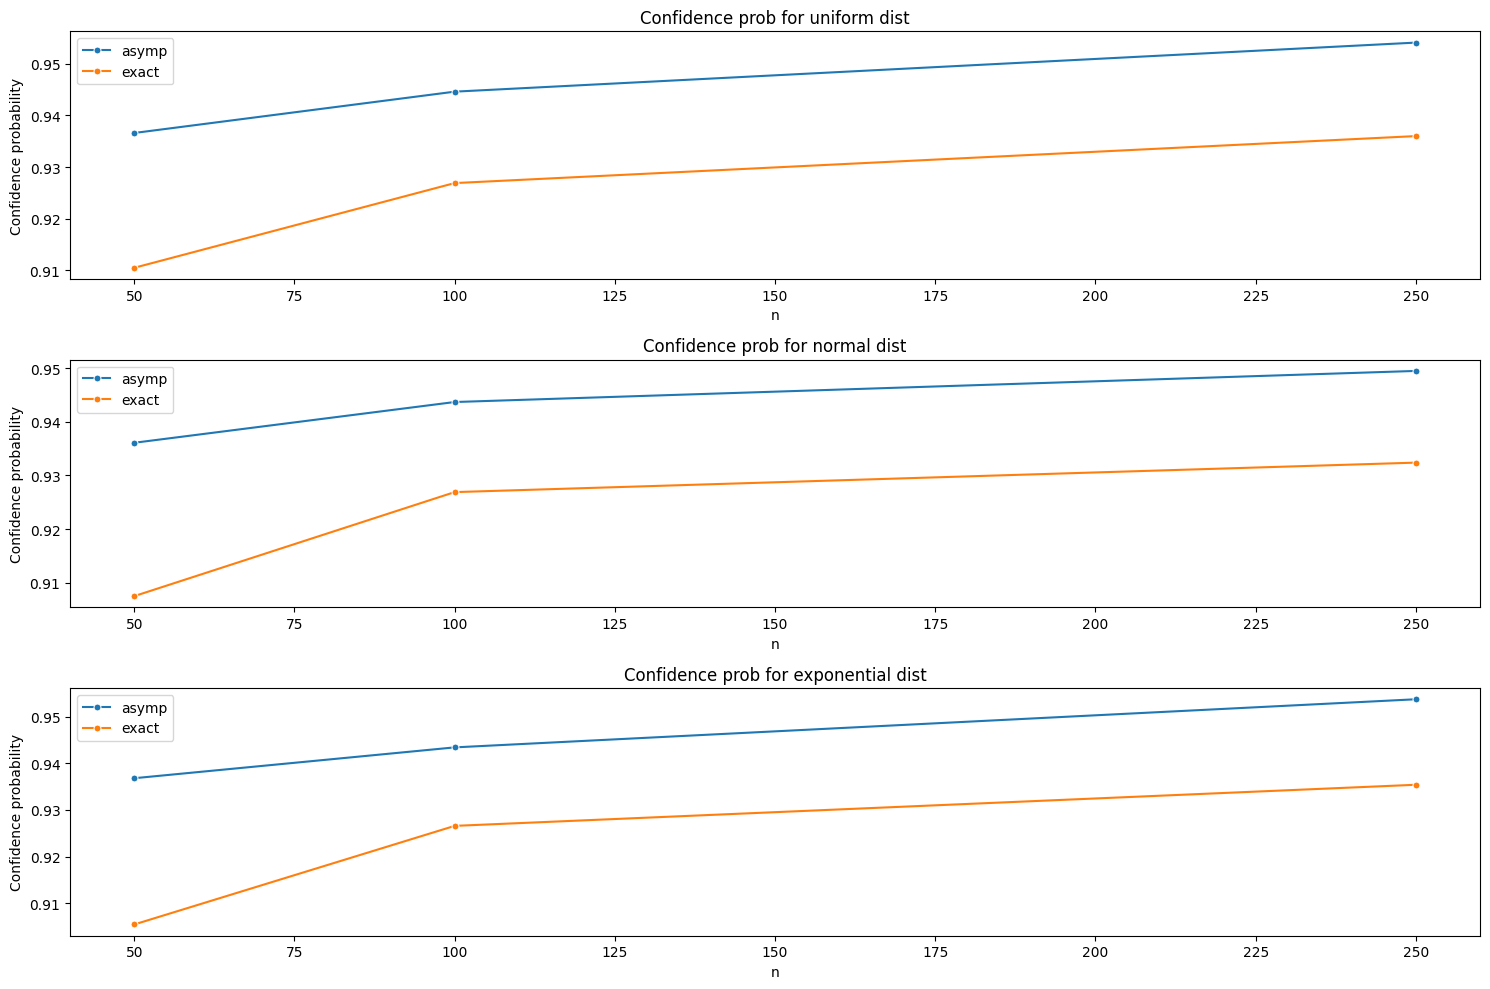

In [20]:
data_1 = pd.DataFrame({'x': n_arange, 'y': prob_asymp_uniform})
data_2 = pd.DataFrame({'x': n_arange, 'y': prob_exact_uniform})

data_3 = pd.DataFrame({'x': n_arange, 'y': prob_asymp_normal})
data_4 = pd.DataFrame({'x': n_arange, 'y': prob_exact_normal})

data_5 = pd.DataFrame({'x': n_arange, 'y': prob_asymp_exponential})
data_6 = pd.DataFrame({'x': n_arange, 'y': prob_exact_exponential})

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='asymp', ax=axes[0])
sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='exact', ax=axes[0])
axes[0].set_title("Confidence prob for uniform dist")
axes[0].set_xlabel("n")
axes[0].set_ylabel("Confidence probability")

sns.lineplot(data=data_3, x='x', y='y', marker='o', markersize=5, label='asymp', ax=axes[1])
sns.lineplot(data=data_4, x='x', y='y', marker='o', markersize=5, label='exact', ax=axes[1])
axes[1].set_title("Confidence prob for normal dist")
axes[1].set_xlabel("n")
axes[1].set_ylabel("Confidence probability")

sns.lineplot(data=data_5, x='x', y='y', marker='o', markersize=5, label='asymp', ax=axes[2])
sns.lineplot(data=data_6, x='x', y='y', marker='o', markersize=5, label='exact', ax=axes[2])
axes[2].set_title("Confidence prob for exponential dist")
axes[2].set_xlabel("n")
axes[2].set_ylabel("Confidence probability")

plt.tight_layout()
plt.show();

# 3

In [34]:
def get_quantile_interval_asymptotic(sample,p, q):
    n = sample.size
    quant = stats.norm.ppf((1 - q) / 2)
    k_1, k_2 = n * p + np.sqrt(n * p * (1 - p)) * quant, n * p - np.sqrt(n * p * (1 - p)) * quant
    k_1, k_2 = int(k_1), int(k_2)

    sample = np.sort(sample)
    # assert(k_1 < n)
    # assert(k_2 < n)
    k_1, k_2 = max(0, k_1), min(n - 1, k_2)
    assert(sample[k_1] < sample[k_2])
    return [
        sample[k_1],
        sample[k_2]
    ]

def get_quantile_interval_exact(sample, p, q):
    n = sample.size
    k_1, k_2 = 0, n - 1

    binom_sum = binom_sums[(n, p)]

    l, r = 0, n - 1
    while (r - l) > 1:
        m = l + (r - l) // 2
        if binom_sum[m] <= (1 - q) / 2:
            l = m
        else:
            r = m
    k_1 = l

    l, r = 0, n - 1
    while (r - l) > 1:
        m = l + (r - l) // 2
        if binom_sum[m] >= (1 + q) / 2:
            r = m
        else:
            l = m
    k_2 = r

    sample = np.sort(sample)
    assert(0 <= k_1 <= n - 1)
    assert(0 <= k_2 <= n - 1)
    assert(sample[k_1] < sample[k_2])
    return [
        sample[k_1],
        sample[k_2]
    ]

In [35]:
get_quantile_interval_asymptotic_5 = lambda sample, q : get_quantile_interval_asymptotic(sample, 0.05, q)
get_quantile_interval_exact_5 = lambda sample, q : get_quantile_interval_exact(sample, 0.05, q)

estimate_interval_prob_asymp_uniform_5     = np.vectorize(lambda n : estimate_interval_prob(generator_uniform, get_quantile_interval_asymptotic_5, 0, n=n))
estimate_interval_prob_exact_uniform_5     = np.vectorize(lambda n : estimate_interval_prob(generator_uniform, get_quantile_interval_exact_5, 0, n=n))

estimate_interval_prob_asymp_normal_5      = np.vectorize(lambda n : estimate_interval_prob(generator_normal, get_quantile_interval_asymptotic_5, 0, n=n))
estimate_interval_prob_exact_normal_5      = np.vectorize(lambda n : estimate_interval_prob(generator_normal, get_quantile_interval_exact_5, 0, n=n))

estimate_interval_prob_asymp_exponential_5 = np.vectorize(lambda n : estimate_interval_prob(generator_exponential, get_quantile_interval_asymptotic_5, -1 - np.log(0.5), n=n))
estimate_interval_prob_exact_exponential_5 = np.vectorize(lambda n : estimate_interval_prob(generator_exponential, get_quantile_interval_exact_5, -1 - np.log(0.5), n=n))

In [36]:
get_quantile_interval_asymptotic_1 = lambda sample, q : get_quantile_interval_asymptotic(sample, 0.01, q)
get_quantile_interval_exact_1 = lambda sample, q : get_quantile_interval_exact(sample, 0.01, q)

estimate_interval_prob_asymp_uniform_1     = np.vectorize(lambda n : estimate_interval_prob(generator_uniform, get_quantile_interval_asymptotic_1, 0, n=n))
estimate_interval_prob_exact_uniform_1     = np.vectorize(lambda n : estimate_interval_prob(generator_uniform, get_quantile_interval_exact_1, 0, n=n))

estimate_interval_prob_asymp_normal_1      = np.vectorize(lambda n : estimate_interval_prob(generator_normal, get_quantile_interval_asymptotic_1, 0, n=n))
estimate_interval_prob_exact_normal_1      = np.vectorize(lambda n : estimate_interval_prob(generator_normal, get_quantile_interval_exact_1, 0, n=n))

estimate_interval_prob_asymp_exponential_1 = np.vectorize(lambda n : estimate_interval_prob(generator_exponential, get_quantile_interval_asymptotic_1, -1 - np.log(0.5), n=n))
estimate_interval_prob_exact_exponential_1 = np.vectorize(lambda n : estimate_interval_prob(generator_exponential, get_quantile_interval_exact_1, -1 - np.log(0.5), n=n))

In [37]:
n_arange = [50, 100, 250]
fill_binom_sums(50, 0.01)
fill_binom_sums(100, 0.01)
fill_binom_sums(250, 0.01)

prob_asymp_uniform_1     = estimate_interval_prob_asymp_uniform_1(n_arange)
prob_exact_uniform_1     = estimate_interval_prob_exact_uniform_1(n_arange)

prob_asymp_normal_1      = estimate_interval_prob_asymp_normal_1(n_arange)
prob_exact_normal_1      = estimate_interval_prob_exact_normal_1(n_arange)

prob_asymp_exponential_1 = estimate_interval_prob_asymp_exponential_1(n_arange)
prob_exact_exponential_1 = estimate_interval_prob_exact_exponential_1(n_arange)

100%|██████████| 10000/10000 [00:11<00:00, 847.61it/s]


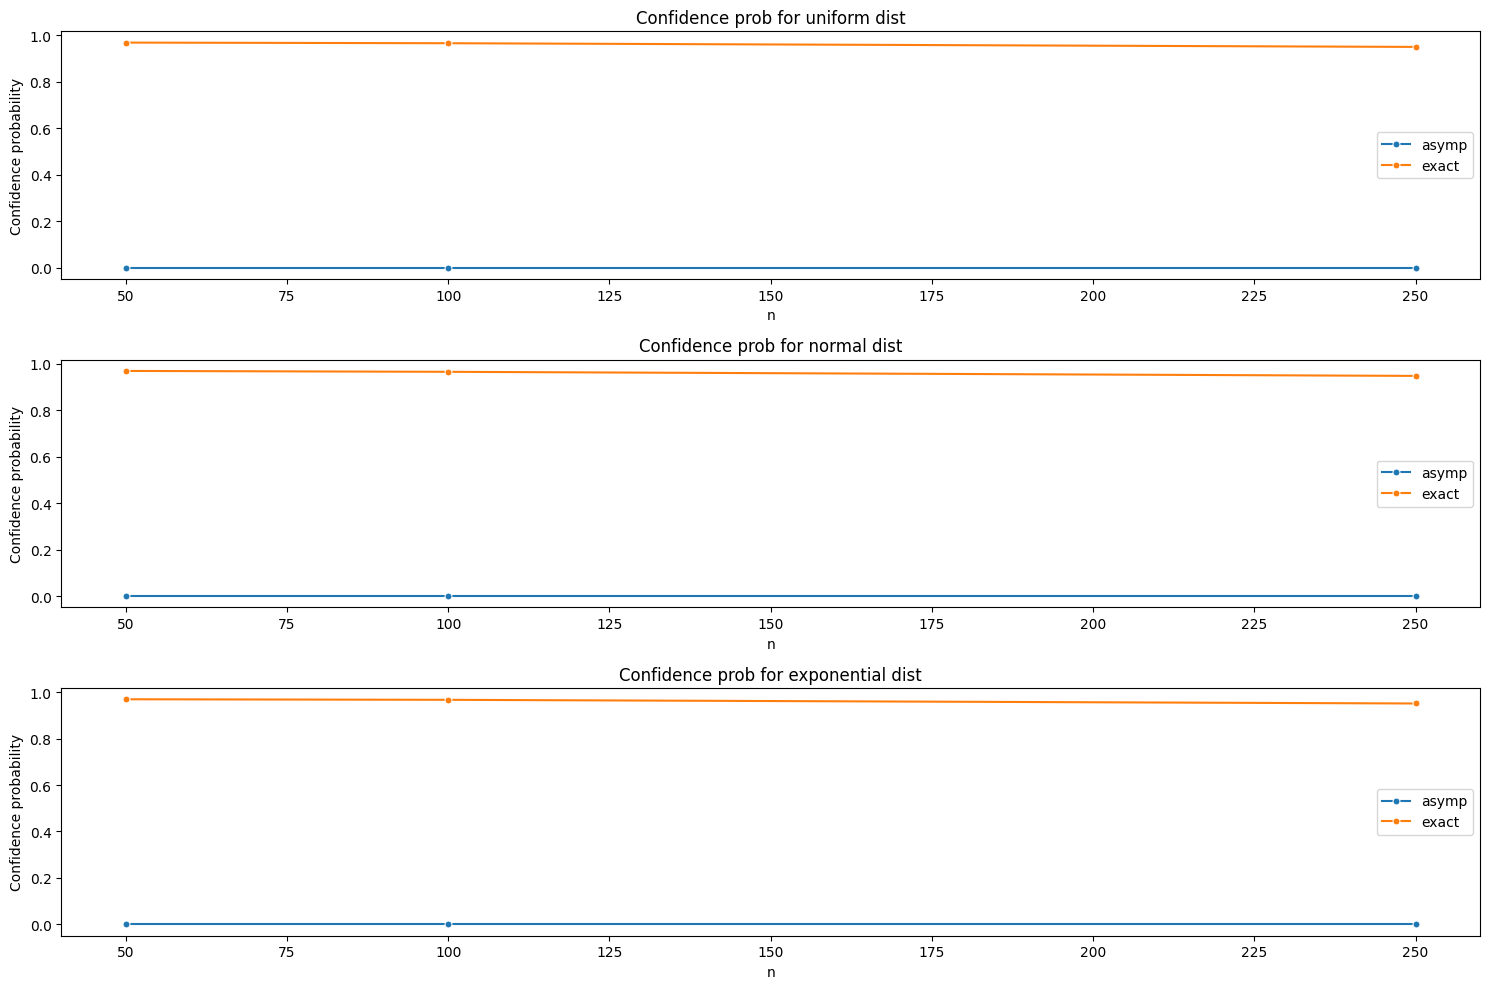

In [38]:
data_1 = pd.DataFrame({'x': n_arange, 'y': prob_asymp_uniform_1})
data_2 = pd.DataFrame({'x': n_arange, 'y': prob_exact_uniform_1})

data_3 = pd.DataFrame({'x': n_arange, 'y': prob_asymp_normal_1})
data_4 = pd.DataFrame({'x': n_arange, 'y': prob_exact_normal_1})

data_5 = pd.DataFrame({'x': n_arange, 'y': prob_asymp_exponential_1})
data_6 = pd.DataFrame({'x': n_arange, 'y': prob_exact_exponential_1})

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='asymp', ax=axes[0])
sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='exact', ax=axes[0])
axes[0].set_title("Confidence prob for uniform dist")
axes[0].set_xlabel("n")
axes[0].set_ylabel("Confidence probability")

sns.lineplot(data=data_3, x='x', y='y', marker='o', markersize=5, label='asymp', ax=axes[1])
sns.lineplot(data=data_4, x='x', y='y', marker='o', markersize=5, label='exact', ax=axes[1])
axes[1].set_title("Confidence prob for normal dist")
axes[1].set_xlabel("n")
axes[1].set_ylabel("Confidence probability")

sns.lineplot(data=data_5, x='x', y='y', marker='o', markersize=5, label='asymp', ax=axes[2])
sns.lineplot(data=data_6, x='x', y='y', marker='o', markersize=5, label='exact', ax=axes[2])
axes[2].set_title("Confidence prob for exponential dist")
axes[2].set_xlabel("n")
axes[2].set_ylabel("Confidence probability")

plt.tight_layout()
plt.show();